# Co-Expression Modules

**Created**: 8 February 2022

These co-expression modules are developed based on recommendations by [Johsnon and Krishnan 2022](https://www.doi.org/10.1186/s13059-021-02568-9). These authors specifically analyzed count data from RNA-Seq rather than microarray data, which has been traditionally used to develop co-expression modules in the past. Their recommendations are:

1. Using Counts adjusted with TMM Factors (CTF) or Counts adjusted with Upper Quartile Factors (CUF) to perform between-sample normalization on count data directly.
2. After normalization, perform an `asinh` normalization.
3. Use Context Likelihood of Relatedness (CLR) to transform the network.

This is the process they used, which I will follow closely:

1. No within-sample normalization.
2. Between-sample normalization using CTF.
3. Retain only protein-coding, antisense RNA, and lncRNA genes.
4. Data transformation using $\text{asinh(x)}=\ln \left(x + \sqrt{x^2 + 1}\right)$
5. Adjacency matrix using Pearson's R between all gene pairs.
6. Network transformation using CLR.

Johnson and Krishnan 2022 do not have any recommendations on generating actual modules. One idea is to use the Dynamic Tree Cut algorithm by [Langfelder, Zhang, and Horvath 2008](https://doi.org/10.1093/bioinformatics/btm563). Options include common clustering algorithms:

1. $k$-means
2. Hierarchical clustering
3. Highly-Connected Subgraphs (HCS)
4. Dynamic Tree Cut

## Environment

In [1]:
if (!requireNamespace("edgeR", quietly=TRUE)) {
    BiocManager::install("edgeR")
}

if (!requireNamespace("igraph", quietly=TRUE)) {
    BiocManager::install("igraph")
}

if (!requireNamespace("RBGL", quietly=TRUE)) {
    BiocManager::install("RBGL")
}

if (!requireNamespace("Rcpp", quietly=TRUE)) {
    BiocManager::install("Rcpp")
}

if (!requireNamespace("Rfast", quietly=TRUE)) {
    install.packages("Rfast")
}

In [2]:
library(tidyverse)
library(edgeR)
library(igraph)
library(Rcpp)
library(data.table)
library(Rfast)
library(cluster)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: limma


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package

In [3]:
Rcpp::sourceCpp("04_Expression/scripts/utils/clr.cpp")

## Load Data

In [4]:
counts <- read.table("/nfs/team282/data/gains_team282/counts_864_20412_hla.txt")

In [5]:
ga.prefix.filter <- grepl("GA", colnames(counts))
colnames(counts)[ga.prefix.filter] <- gsub("^GA", "", colnames(counts)[ga.prefix.filter])

In [6]:
head(counts)

,UK02270173_3,UK15130120_3,UK58000006_3,UK47010004_3,UK42020088_5,UK47490007_3,UK02770164_3,UK02770164_5,UK02630151_3,UK42150107_1,⋯,UK59070043_3,UK59070043_5,UK02510223_3,UK02XX0336_5,UK29090086_3,UK02XX0335_1,UK02XX0334_3,UK01210130_3,UK01210130_5,UK01380125_1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000230521,24,21,10,4,5,10,15,20,17,9,⋯,9,13,25,22,17,3,35,23,41,13
ENSG00000225864,40,15,16,23,5,35,5,20,4,40,⋯,18,23,27,3,14,12,17,13,15,10
ENSG00000227766,54,10,18,19,17,7,3,5,3,32,⋯,12,10,9,1,16,9,9,14,5,3
ENSG00000237669,23,26,30,16,9,32,30,21,22,32,⋯,33,15,32,32,19,23,27,32,24,40
ENSG00000271581,187,64,79,117,81,91,18,41,39,130,⋯,135,54,61,18,43,60,49,70,67,46
ENSG00000285647,0,1,0,1,18,0,0,1,17,64,⋯,286,122,1,0,0,13,11,2,2,12


In [7]:
gene.info <- read.table("/nfs/team282/data/gains_team282/gene_info_864_20412_hla.txt")

In [8]:
head(gene.info)

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,⋯,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,protein_id,protein_version,ccds_id
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
ENSG00000230521,6,29887294,29888268,975,-,havana,gene,NA,NA,ENSG00000230521,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000225864,6,29722981,29723971,991,-,havana,gene,NA,NA,ENSG00000225864,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000227766,6,29942075,29943067,993,-,havana,gene,NA,NA,ENSG00000227766,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000237669,6,30006121,30007116,996,-,havana,gene,NA,NA,ENSG00000237669,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000271581,6,31356647,31357637,991,+,havana,gene,NA,NA,ENSG00000271581,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000285647,6,31367057,31376088,9032,+,havana,gene,NA,NA,ENSG00000285647,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Between-Sample Normalization

I will perform between-sample normalization using the trimmed mean of $M$ values (TMM) on the count data directly. This is a method Johnson and Krishnan 2022 refer to as Counts Adjusted with TMM Factors (CTF). 

In [9]:
norm.factors <- edgeR::calcNormFactors(counts)

In [10]:
normalized.counts <- t(apply(counts, 1, function(x) { x / norm.factors }))

In [11]:
head(normalized.counts)

,UK02270173_3,UK15130120_3,UK58000006_3,UK47010004_3,UK42020088_5,UK47490007_3,UK02770164_3,UK02770164_5,UK02630151_3,UK42150107_1,⋯,UK59070043_3,UK59070043_5,UK02510223_3,UK02XX0336_5,UK29090086_3,UK02XX0335_1,UK02XX0334_3,UK01210130_3,UK01210130_5,UK01380125_1
ENSG00000230521,21.55001,17.2447538,9.724169,4.613221,5.71868,11.313561,14.346532,17.253619,22.313038,10.21478,⋯,9.162787,12.680394,18.5900523,18.4578591,17.99854,3.677036,31.788661,18.360747,32.832300,12.634999
ENSG00000225864,35.91669,12.3176813,15.558671,26.526021,5.71868,39.597464,4.782177,17.253619,5.250127,45.39902,⋯,18.325573,22.434543,20.0772565,2.5169808,14.82233,14.708143,15.440207,10.377813,12.011817,9.719230
ENSG00000227766,48.48753,8.2117875,17.503505,21.912800,19.44351,7.919493,2.869306,4.313405,3.937595,36.31921,⋯,12.217049,9.754149,6.6924188,0.8389936,16.93980,11.031107,8.174227,11.176107,4.003939,2.915769
ENSG00000237669,20.65210,21.3506476,29.172508,18.452884,10.29362,36.203396,28.693065,18.116300,28.875696,36.31921,⋯,33.596884,14.631224,23.7952669,26.8477951,20.11602,28.190607,24.522681,25.545387,19.218907,38.876921
ENSG00000271581,167.91052,52.5554402,76.820938,134.936714,92.64262,102.953408,17.215839,35.369920,51.188733,147.54681,⋯,137.441800,52.672406,45.3597276,15.1018848,45.52573,73.540713,44.504126,55.880534,53.652783,44.708459
ENSG00000285647,0.00000,0.8211788,0.000000,1.153305,20.58725,0.000000,0.000000,0.862681,22.313038,72.63843,⋯,291.172999,119.000622,0.7436021,0.0000000,0.00000,15.933821,9.990722,1.596587,1.601576,11.663076


## Gene Type Filtering

I filter out any genes that are not protein-coding, antisense RNA, or lncRNA genes. This is done after normalization to ensure that the library size correction is calculated using all the counts available.

In Ensembl, `protein_coding` stands for the protein coding genes. The `lncRNA` biotype is for long non-coding RNAs. I include `miRNA`, `piRNA`, and `siRNA` as antisense RNAs. I also included immunoglobulin and T-cell receptor variable regions, as they are relevant to sepsis.

These filters nominate 18,681 genes for co-expression analysis.

In [12]:
gene.filter <- gene.info$gene_biotype == "protein_coding"
gene.filter <- gene.filter | gene.info$gene_biotype == "lncRNA"
gene.filter <- gene.filter | gene.info$gene_biotype == "miRNA"
gene.filter <- gene.filter | gene.info$gene_biotype == "piRNA"
gene.filter <- gene.filter | gene.info$gene_biotype == "siRNA"
gene.filter <- gene.filter | grepl("^IG_", gene.info$gene_biotype)
gene.filter <- gene.filter | grepl("^TR_", gene.info$gene_biotype)
gene.filter <- gene.filter & !is.na(gene.info$gene_biotype)

In [13]:
gene.info.filtered <- gene.info[gene.filter,]

In [14]:
dim(gene.info.filtered)

[1] 18681    27

In [15]:
head(gene.info.filtered)

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,⋯,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,protein_id,protein_version,ccds_id
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
ENSG00000285647,6,31367057,31376088,9032,+,havana,gene,NA,NA,ENSG00000285647,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000204435,6,31665236,31670343,5108,+,ensembl_havana,gene,NA,NA,ENSG00000204435,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000231074,6,30286690,30327382,40693,-,havana,gene,NA,NA,ENSG00000231074,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000206337,6,31463170,31478936,15767,+,ensembl_havana,gene,NA,NA,ENSG00000206337,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000206503,6,29941260,29945884,4625,+,ensembl_havana,gene,NA,NA,ENSG00000206503,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ENSG00000234745,6,31269491,31357188,87698,-,ensembl_havana,gene,NA,NA,ENSG00000234745,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [16]:
normalized.counts.filtered <- normalized.counts[rownames(gene.info.filtered),]

In [17]:
head(normalized.counts.filtered)

,UK02270173_3,UK15130120_3,UK58000006_3,UK47010004_3,UK42020088_5,UK47490007_3,UK02770164_3,UK02770164_5,UK02630151_3,UK42150107_1,⋯,UK59070043_3,UK59070043_5,UK02510223_3,UK02XX0336_5,UK29090086_3,UK02XX0335_1,UK02XX0334_3,UK01210130_3,UK01210130_5,UK01380125_1
ENSG00000285647,0.0000,8.211788e-01,0.0000,1.153305e+00,20.58725,0.0000,0.0000,8.626810e-01,22.31304,72.63843,⋯,291.1730,119.0006,7.436021e-01,0.0000,0.0000,15.93382,9.990722e+00,1.596587e+00,1.601576e+00,11.66308
ENSG00000204435,443.5711,6.298441e+02,365.6288,5.028411e+02,761.72821,750.0891,391.1821,3.951079e+02,630.01518,513.00890,⋯,400.1084,377.4856,4.052631e+02,411.1069,496.5480,720.69899,4.332340e+02,4.334733e+02,4.051986e+02,498.59651
ENSG00000231074,563.8920,3.958082e+02,333.5390,2.099016e+02,391.15773,247.7670,367.2712,4.244390e+02,259.88126,356.38229,⋯,303.3900,306.2803,4.141864e+02,339.7924,377.9694,365.25221,5.440402e+02,4.741862e+02,4.692617e+02,462.63536
ENSG00000206337,5841.8496,2.829782e+03,3403.4593,6.222082e+03,2782.70981,3432.5345,3703.3182,3.774229e+03,4601.73588,4175.57462,⋯,3892.1482,3690.9701,2.303679e+03,3106.7933,5646.2487,4740.92466,6.156101e+03,3.636226e+03,3.715655e+03,2650.43407
ENSG00000206503,88215.8792,1.038652e+05,64689.0643,1.516400e+05,142363.11360,105755.7767,52786.6309,7.223745e+04,143009.50844,151111.76418,⋯,87412.9849,76183.8080,6.203129e+04,63049.5299,138010.7082,113256.37569,6.991235e+04,7.831737e+04,7.287009e+04,75416.36650
ENSG00000234745,216755.4258,2.057644e+05,144883.3166,2.391505e+05,206798.91517,257246.6249,119071.4358,1.624385e+05,358410.38621,244326.16156,⋯,142428.3922,126543.5057,9.380243e+04,143722.9593,255535.8986,349135.76259,2.089705e+05,1.341755e+05,1.247355e+05,120012.08221


## Data Transformation

The authors recommend using an $\text{asinh}(x)$ transformation rather than a pure log transformation to avoid the use of pseudocounts to bias low counts.

In [18]:
gene.exp <- apply(normalized.counts.filtered, 1, asinh)

In [19]:
head(gene.exp)

,ENSG00000285647,ENSG00000204435,ENSG00000231074,ENSG00000206337,ENSG00000206503,ENSG00000234745,ENSG00000204525,ENSG00000204257,ENSG00000242574,ENSG00000204252,⋯,ENSG00000288156,ENSG00000288234,ENSG00000288253,ENSG00000288302,ENSG00000288398,ENSG00000288538,ENSG00000288559,ENSG00000288562,ENSG00000288573,ENSG00000288582
UK02270173_3,0.0000000,6.788007,7.028011,9.365950,12.08069,12.97967,12.76857,7.435596,7.572960,6.710155,⋯,8.020318,0.807318,3.476797,4.679900,4.477419,4.477419,4.223271,4.1120985,2.891141,6.094863
UK15130120_3,0.7491208,7.138620,6.674078,8.641102,12.24400,12.92763,12.52339,7.913713,7.729588,6.423061,⋯,8.381838,2.581317,3.387647,5.091290,5.205693,3.674830,4.133976,1.2712212,2.449524,6.451973
UK58000006_3,0.0000000,6.594768,6.502909,8.825695,11.77049,12.57683,12.34686,7.289242,7.560860,5.689069,⋯,8.214786,1.791949,2.616439,4.725698,4.493943,4.672597,4.131171,2.6164391,1.791949,6.811507
UK47010004_3,0.9857332,6.913422,6.039791,9.429007,12.62241,13.07800,12.89998,7.024044,6.466993,4.391281,⋯,8.534262,2.233619,2.632719,4.014159,4.269962,5.025477,3.726730,2.4526518,1.572911,5.710987
UK42020088_5,3.7184084,7.328737,6.662260,8.624328,12.55928,12.93265,12.81569,7.295147,6.225614,5.509595,⋯,8.617316,2.225478,1.565272,4.516446,4.353973,5.391816,3.963303,0.9794495,2.444444,5.717807
UK47490007_3,0.0000000,7.313340,6.205640,8.834201,12.26203,13.15094,12.84701,8.203035,7.580449,5.758217,⋯,9.052455,3.650453,3.302824,5.270938,4.454286,3.812784,3.525481,4.2179785,1.555309,6.751460


## Network Construction

I will use Pearson's $R$ as a measure of similarity between any two genes.

In [20]:
adjacency <- Rfast::cora(gene.exp)

In [21]:
head(adjacency)

,ENSG00000285647,ENSG00000204435,ENSG00000231074,ENSG00000206337,ENSG00000206503,ENSG00000234745,ENSG00000204525,ENSG00000204257,ENSG00000242574,ENSG00000204252,⋯,ENSG00000288156,ENSG00000288234,ENSG00000288253,ENSG00000288302,ENSG00000288398,ENSG00000288538,ENSG00000288559,ENSG00000288562,ENSG00000288573,ENSG00000288582
ENSG00000285647,1.000000000,0.07375442,0.005854862,0.25856514,0.273236957,0.2559725,0.3377687,0.04076354,0.06498784,-0.03802942,⋯,0.09152316,0.06727860,-0.05639881,0.03861621,0.03128804,0.07967416,0.07811030,0.04912278,0.03082431,0.14132562
ENSG00000204435,0.073754416,1.00000000,0.103173695,0.09844292,0.545945393,0.5965961,0.5460416,0.23323390,0.07851515,-0.03055019,⋯,0.66296101,0.24393987,-0.29732677,0.66957205,0.09004843,0.21427702,-0.11204925,-0.07973876,-0.05301598,0.26287825
ENSG00000231074,0.005854862,0.10317370,1.000000000,0.29924856,-0.004141615,-0.0404531,-0.1030066,0.47453980,0.52030120,0.60339676,⋯,-0.27552678,-0.10200399,0.29143951,-0.15461120,0.64890079,0.02317446,0.39556213,-0.13177225,0.43809331,-0.07668759
ENSG00000206337,0.258565141,0.09844292,0.299248563,1.00000000,0.663055067,0.6502017,0.5810074,0.32924116,0.41407920,0.24881336,⋯,0.02388220,0.06910771,0.09174480,-0.01407840,0.31729228,0.14743106,0.41165248,0.05892553,0.08483948,0.30909545
ENSG00000206503,0.273236957,0.54594539,-0.004141615,0.66305507,1.000000000,0.8632646,0.8099359,0.28523073,0.23531879,-0.01385377,⋯,0.42994896,0.12733483,-0.14947848,0.40088800,0.13972838,0.13183690,0.01161974,0.09431677,-0.06851351,0.38785590
ENSG00000234745,0.255972498,0.59659607,-0.040453103,0.65020174,0.863264576,1.0000000,0.9274792,0.24687893,0.19893131,-0.02171378,⋯,0.53883516,0.20859414,-0.19083069,0.45827185,0.09887477,0.23111011,0.09153003,0.07201040,-0.13391083,0.40534787


## Network Transformation

Instead of WTO (which is used in WGCNA), I will use Context Likelihood of Relatedness (CLR) as recommended by Johnson and Krishnan 2022.

Although Johnson and Krishnan used an implementation from [Sleipnir](https://functionlab.github.io/sleipnir-docs/index.html), it is a large C++ program that I do not need in its entirety. Instead, I rewrote a C++ version of CLR for myself.

In [22]:
network <- clr(adjacency)

In [23]:
rownames(network) <- rownames(adjacency)
colnames(network) <- colnames(adjacency)

In [24]:
head(network)

,ENSG00000285647,ENSG00000204435,ENSG00000231074,ENSG00000206337,ENSG00000206503,ENSG00000234745,ENSG00000204525,ENSG00000204257,ENSG00000242574,ENSG00000204252,⋯,ENSG00000288156,ENSG00000288234,ENSG00000288253,ENSG00000288302,ENSG00000288398,ENSG00000288538,ENSG00000288559,ENSG00000288562,ENSG00000288573,ENSG00000288582
ENSG00000285647,18.3573540,0.5082416,1.0043695,2.8724216,3.106043,2.834010,3.996280,0.2854209,0.3431835,1.4944433,⋯,0.5861384,0.3579622,1.4942763,0.2671115,0.7969602,0.5188962,0.6881934,0.6553379,0.2682476,1.287871
ENSG00000204435,0.5082416,4.3657461,0.5050882,0.5965805,2.355238,2.357882,2.094180,0.5146822,0.4281236,1.1600705,⋯,2.5118005,0.6070174,2.4535810,3.0637179,0.5846414,0.3104342,1.6894150,0.9647993,1.0200113,1.057347
ENSG00000231074,1.0043695,0.5050882,4.4143084,0.6399677,1.168472,1.395645,1.705058,1.7321979,1.9415304,2.5850654,⋯,2.3253542,1.6175685,1.5655078,1.7763377,2.7163618,0.9307207,0.9798339,1.4017006,2.3605206,1.496659
ENSG00000206337,2.8724216,0.5965805,0.6399677,5.9569911,3.483486,3.096841,2.647168,1.0822989,1.5761672,0.5066073,⋯,0.9728322,0.7200750,0.7071934,1.1953171,0.8436680,0.2628163,1.3312002,1.0166282,0.6302582,1.404957
ENSG00000206503,3.1060430,2.3552379,1.1684720,3.4834858,5.858224,4.522284,4.182750,0.9103705,0.5437791,1.1582483,⋯,1.6510674,0.1575602,1.7578388,1.7694045,0.2741403,0.1602134,1.0975660,0.9661979,1.2876538,2.070246
ENSG00000234745,2.8340100,2.3578821,1.3956453,3.0968412,4.522284,4.934592,4.497798,0.5784935,0.2559218,1.2195592,⋯,2.0071092,0.3986997,1.9704557,1.9373560,0.5880068,0.3963414,0.6623296,0.9306644,1.7053174,2.062316


## Module Construction

I built a distance matrix using the CLR values by subtracting the network matrix from the maximum value in the matrix. This guarantees that the distance between any two genes is greater than or equal to 0.

I performed hierarchical clustering on the distance matrix.

In [25]:
d.mtx <- max(network) - network

In [26]:
h <- hclust(as.dist(d.mtx))

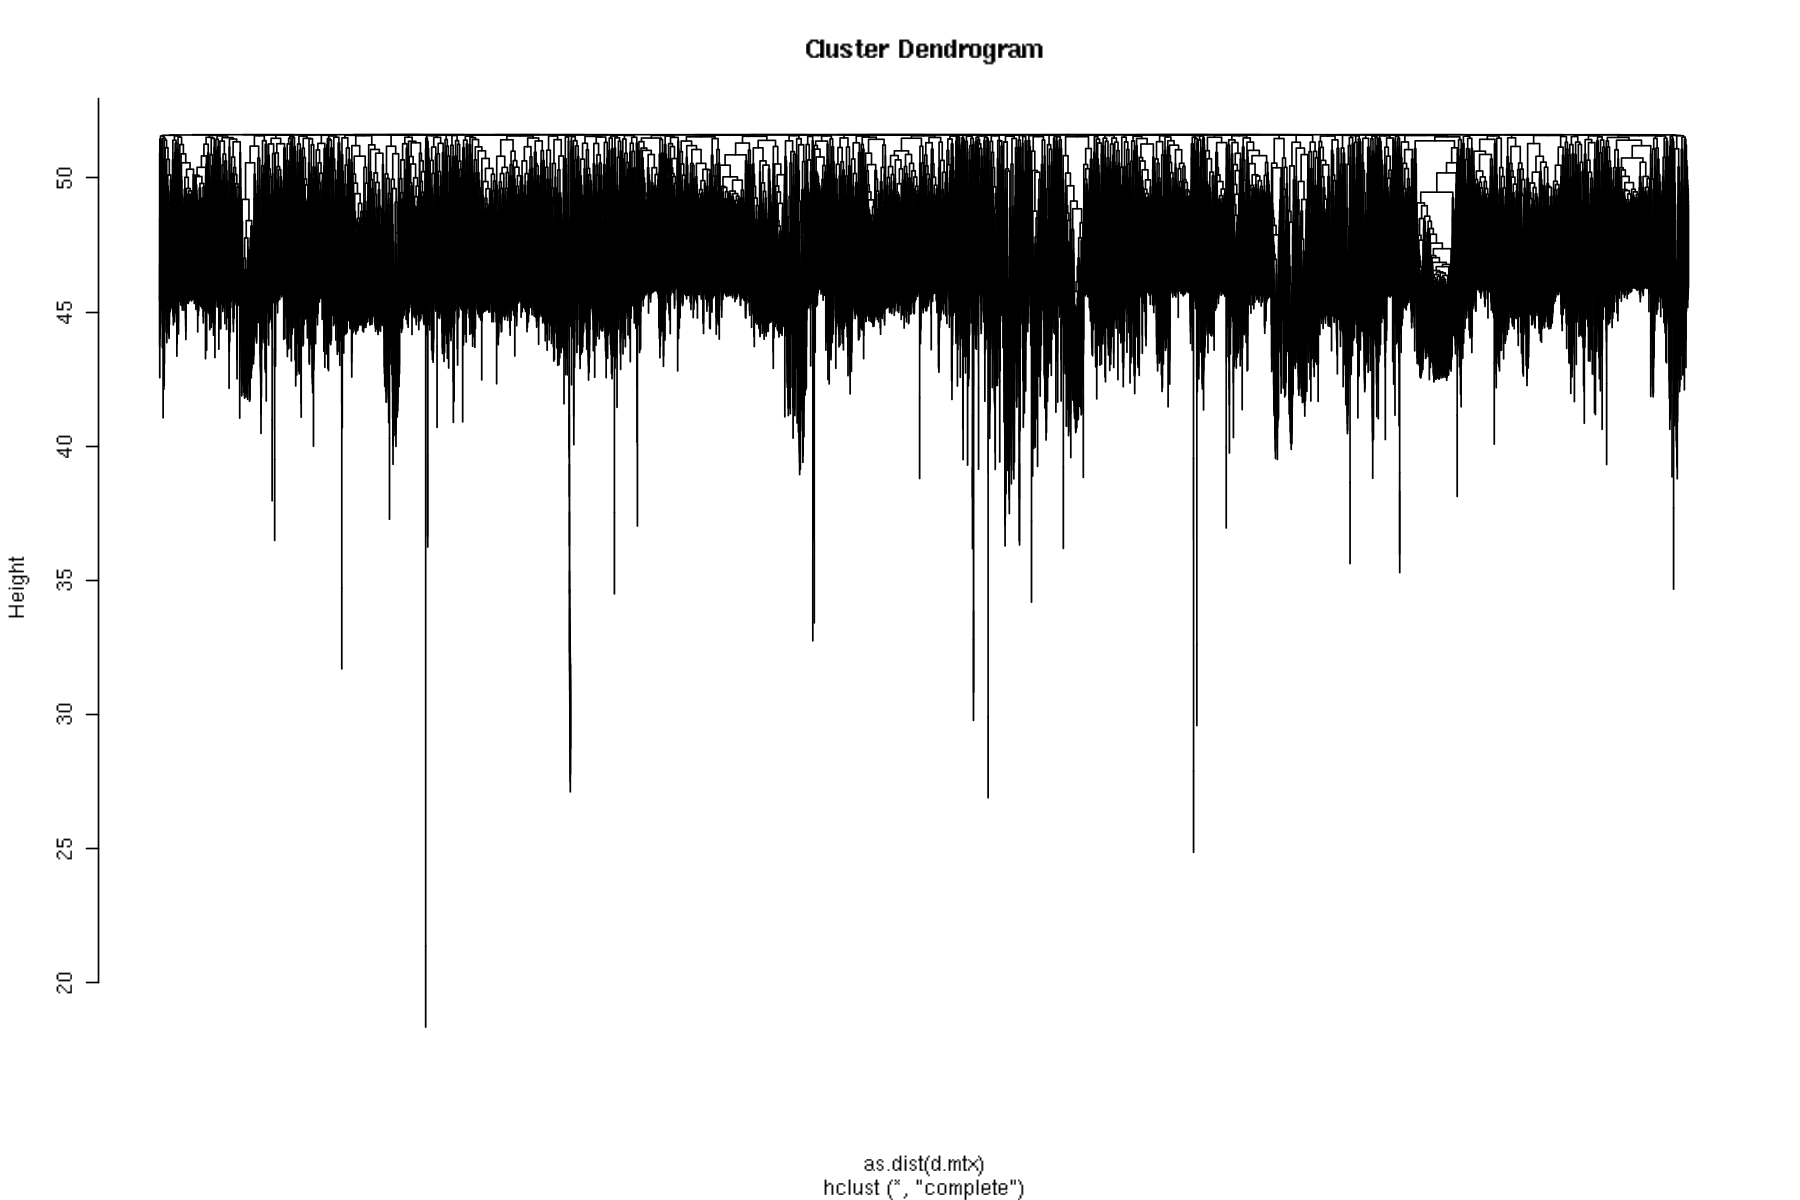

In [27]:
options(repr.plot.width=15, repr.plot.height=10)
plot(h, labels=FALSE)

I decided to use the median silhouette width to determine how many clusters to generate. I started by enumerating the median silhouette widths for clusters with $k=10$ to $k=200$ at intervals of 10. The highest median widths were between 10 and 50, so I focused on that region further.

In [28]:
num.clusters <- seq(10, 200, by=10)
clusters <- lapply(num.clusters, function(k) { cutree(h, k=k) })

In [29]:
silhouette.scores <- sapply(clusters, function(x) { median(silhouette(x, dmatrix=d.mtx)[,3]) })

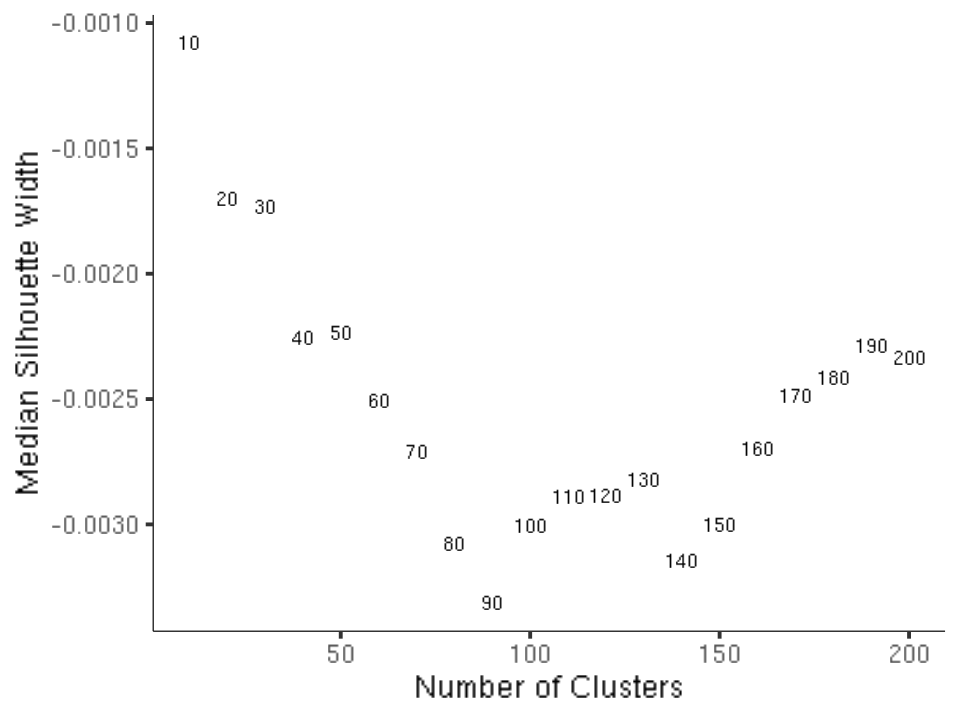

In [30]:
options(repr.plot.width=8, repr.plot.height=6)

data.frame(
    Num.Clusters=num.clusters,
    Median.Silhouette.Width=silhouette.scores
) %>%
    ggplot() +
    geom_text(aes(x=Num.Clusters, y=Median.Silhouette.Width, label=Num.Clusters)) +
    xlab("Number of Clusters") + ylab("Median Silhouette Width") +
    ggplot_theme

I tried cluster numbers from $k=10$ to $k=50$. Although $k=10$ and $k=11$ performed the best, the module sizes would be to large. The third best value was at $k=26$, which is what I decided to use for module construction.

In [31]:
num.clusters <- seq(10, 50, by=1)
clusters <- lapply(num.clusters, function(k) { cutree(h, k=k) })

In [32]:
silhouette.scores <- sapply(clusters, function(x) { median(silhouette(x, dmatrix=d.mtx)[,3]) })

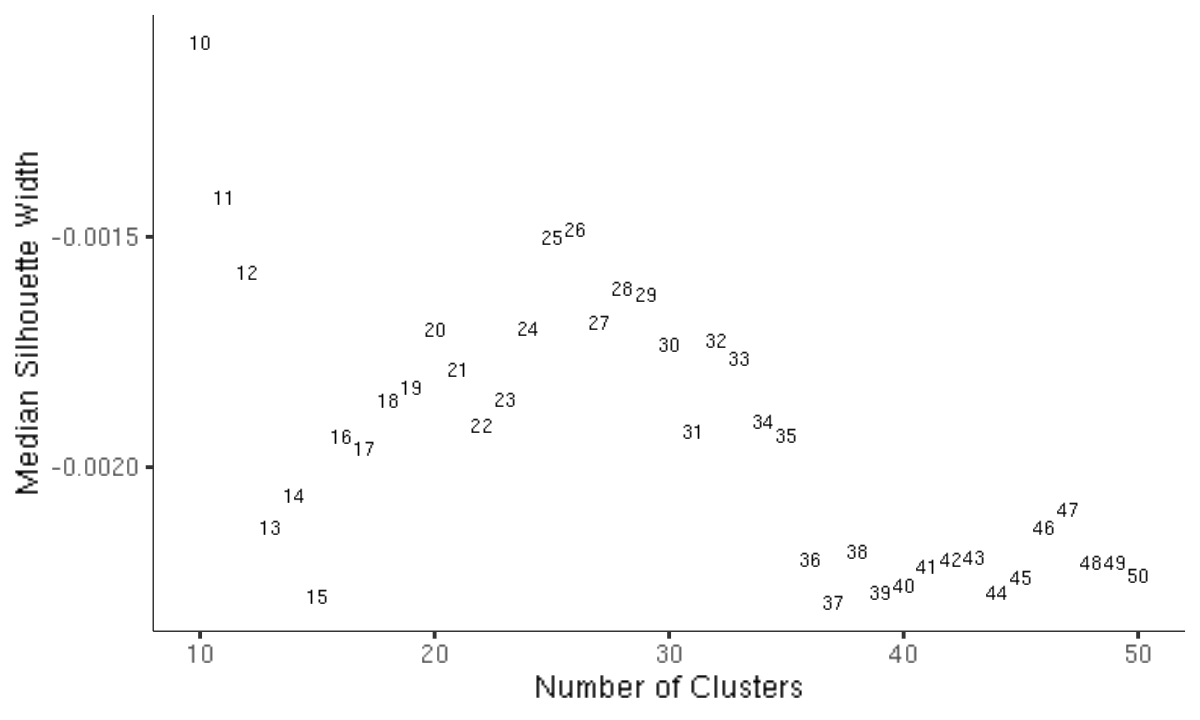

In [33]:
options(repr.plot.width=10, repr.plot.height=6)

data.frame(
    Num.Clusters=num.clusters,
    Median.Silhouette.Width=silhouette.scores
) %>%
    ggplot() +
    geom_text(aes(x=Num.Clusters, y=Median.Silhouette.Width, label=Num.Clusters)) +
    xlab("Number of Clusters") + ylab("Median Silhouette Width") +
    ggplot_theme

In [34]:
modules.k = 26
modules <- cutree(h, k=modules.k)

In [35]:
table(modules)

modules
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
 997  351  504  541  456  646 1010  757  530 1042  358  529  453 1364 1007  617 
  17   18   19   20   21   22   23   24   25   26 
 678 1796  426 1226  424  807  702  541  578  341 

## Save Modules

First, I will reassign module numbering by the number of genes in each module in descending order. All genes that were filtered out in the process of generating co-expression modules will be assigned to Module 0.

In [36]:
module.label.map <- as.list(1:modules.k)
names(module.label.map) <- order(table(modules), decreasing=TRUE)

In [37]:
modules.reassigned <- sapply(modules, function(gene.assignment) { module.label.map[[as.character(gene.assignment)]] })

In [38]:
table(modules.reassigned)

modules.reassigned
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1796 1364 1226 1042 1010 1007  997  807  757  702  678  646  617  578  541  541 
  17   18   19   20   21   22   23   24   25   26 
 530  529  504  456  453  426  424  358  351  341 

In [39]:
modules <- data.frame(
    Gene=rownames(network),
    Module=modules.reassigned
) %>%
    dplyr::arrange(Module) %>%
    dplyr::mutate(Module=paste0("Module_", Module))

modules <- dplyr::bind_rows(
    modules,
    data.frame(
        Gene=setdiff(gene.info$gene_id, modules$Gene),
        Module="Unassigned"
    )
)

head(modules)
tail(modules)

,Gene,Module
,<chr>,<chr>
ENSG00000001167,ENSG00000001167,Module_1
ENSG00000001630,ENSG00000001630,Module_1
ENSG00000002822,ENSG00000002822,Module_1
ENSG00000002834,ENSG00000002834,Module_1
ENSG00000004864,ENSG00000004864,Module_1
ENSG00000005108,ENSG00000005108,Module_1


,Gene,Module
,<chr>,<chr>
...20407,ENSG00000285799,Unassigned
...20408,ENSG00000286025,Unassigned
...20409,ENSG00000286215,Unassigned
...20410,ENSG00000286640,Unassigned
...20411,ENSG00000288349,Unassigned
...20412,ENSG00000288393,Unassigned


I'll calculate the first principal component for each module to get the module eigengenes.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



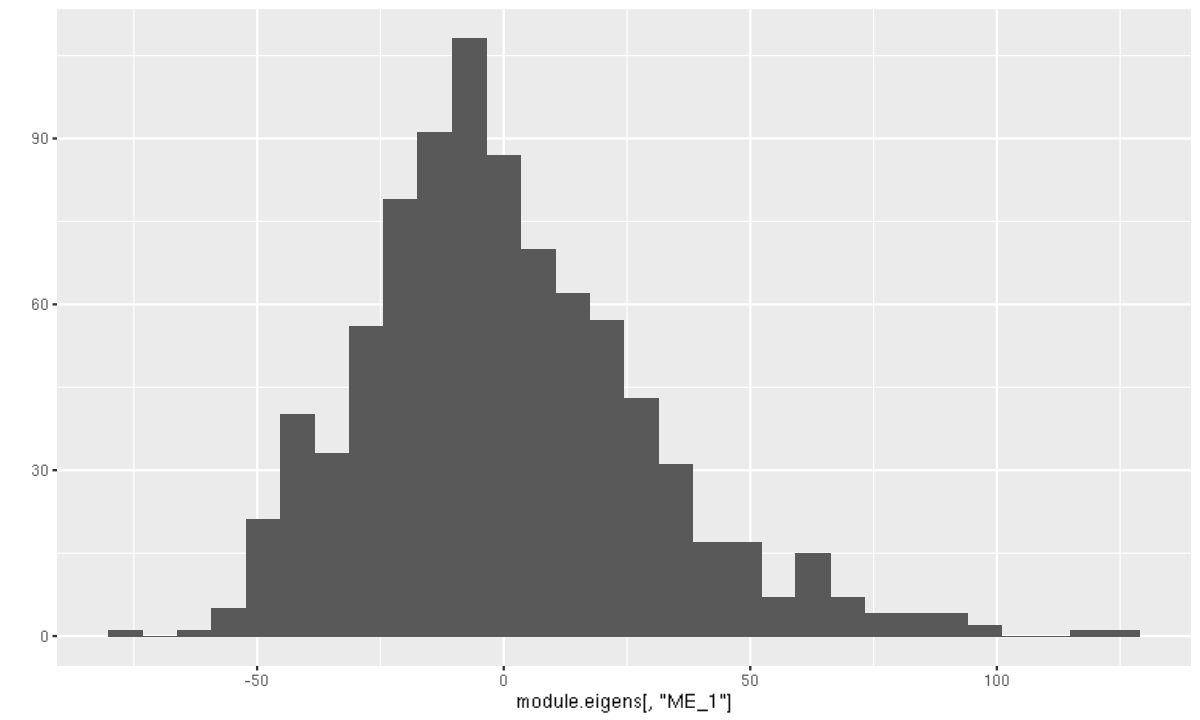

In [59]:
qplot()

In [67]:
module.eigens <- sapply(1:modules.k, function(k) { svd(scale(gene.exp[,modules.reassigned == k]))$u[,1] })

In [70]:
colnames(module.eigens) <- paste0("ME_", 1:modules.k)
rownames(module.eigens) <- rownames(gene.exp)

In [71]:
head(module.eigens)

,ME_1,ME_2,ME_3,ME_4,ME_5,ME_6,ME_7,ME_8,ME_9,ME_10,⋯,ME_17,ME_18,ME_19,ME_20,ME_21,ME_22,ME_23,ME_24,ME_25,ME_26
UK02270173_3,-0.01611500,-8.739980e-03,0.017559222,-0.027088697,-0.014542344,-0.051399999,0.046803451,-0.034436746,-0.039087399,0.007150941,⋯,-0.028049775,-0.008129458,-0.0366723556,-0.025875130,-0.028752001,-0.029350268,-0.033465625,0.010493801,0.00122623,-0.024552444
UK15130120_3,0.02461525,6.068727e-05,0.019840461,-0.001849399,0.015906557,-0.042843776,0.027117922,0.008308366,-0.052541896,0.002858297,⋯,-0.051424350,0.032422585,-0.0460940914,-0.020925083,-0.045620906,0.001037124,-0.046257297,-0.006227393,0.03094529,-0.009247218
UK58000006_3,-0.02437838,-2.023844e-02,0.011494096,-0.016979651,-0.012391572,-0.013535154,0.028149929,-0.036083414,0.006142253,-0.012787746,⋯,0.003129053,-0.042368235,-0.0007423982,-0.016100324,-0.004058335,-0.004009045,-0.033120185,0.022609639,-0.02542599,-0.015154949
UK47010004_3,-0.01080795,8.698390e-03,0.007577865,0.013627892,-0.004619325,0.002682967,-0.009939209,0.006247252,0.002732679,0.019114337,⋯,0.011108371,-0.017369738,-0.0004493176,-0.008345582,0.019301199,-0.016442041,0.005647093,0.014716956,-0.01134338,0.010130191
UK42020088_5,-0.01290457,3.118465e-02,0.015750574,-0.011878781,-0.017614265,0.003339252,0.002623253,-0.001437406,0.001814986,0.002952335,⋯,-0.003885891,0.029755732,-0.0015589206,0.031183587,-0.011606689,-0.007412970,0.003816931,-0.025490423,0.02710027,-0.015256640
UK47490007_3,0.01069874,3.416032e-02,0.013941807,0.025513984,0.009282998,0.008292475,-0.022579807,0.027908019,-0.012258133,-0.053561098,⋯,-0.018626363,0.027655567,-0.0135092661,-0.027328549,-0.005307802,-0.020544032,-0.016863817,0.000202337,0.02977359,-0.003884780


In [45]:
var.explained <- sapply(
    1:modules.k,
    function(k) { summary(prcomp(scale(gene.exp[,modules.reassigned == k])))$importance["Proportion of Variance", "PC1"] }
)

In [46]:
module.var.explained <- data.frame(
    Module=paste0("ME_", 1:modules.k),
    Var.Explained=var.explained
)

head(module.var.explained)

,Module,Var.Explained
,<chr>,<dbl>
1,ME_1,0.45732
2,ME_2,0.45434
3,ME_3,0.33293
4,ME_4,0.42623
5,ME_5,0.45450
6,ME_6,0.40946


In [72]:
write.csv(modules, "/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/gene_expression/modules.clr.csv", quote=F, row.names=F)
write.csv(module.eigens, "/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/gene_expression/eigengenes.clr.csv", quote=F, row.names=T)
write.csv(module.var.explained, "/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/gene_expression/variance.explained.clr.csv", quote=F, row.names=F)